In [17]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("jsbChorales-1000", attn_implementation="eager")

In [11]:
from anticipation.sample import generate
from anticipation.convert import events_to_midi
import midi2audio
from IPython.display import Audio

fs = midi2audio.FluidSynth('/Users/lancelotblanchard/.fluidsynth/default_sound_font.sf2')

# the MIDI synthesis script
def synthesize(fs, tokens):
    mid = events_to_midi(tokens)
    mid.save('tmp.mid')
    fs.midi_to_audio('tmp.mid', 'tmp.wav')
    return 'tmp.wav'

In [4]:
from anticipation.vocab import CONTROL_OFFSET
import anticipation.ops as ops

# Create a top line melody
melody = [0, 10049, 11060, 50, 10049, 11064, 100, 10049, 11067, 150, 10049, 11064, 200, 10049, 11060, 250, 10049, 11064, 300, 10049, 11067, 350, 10049, 11064]

# Anticipate everything
melody = [CONTROL_OFFSET+x for x in melody]

# Generate an accompaniment
accompaniment = generate(model, 0, 4, controls=melody, top_p=0.98, active_instruments=[1,2,3])

Audio(synthesize(fs, ops.combine(accompaniment, melody)))

  0%|          | 0/400 [00:00<?, ?it/s]

 94%|█████████▍| 375/400 [00:04<00:00, 90.90it/s] 

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'tmp.wav'..



fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


In [17]:
from anticipation.sample import add_token
from anticipation.vocab import ANTICIPATE, CONTROL_OFFSET
from tqdm import tqdm

# Trying to generate tokens manually
z = [ANTICIPATE]
top_p = 0.98
tokens = []
result = []
current_time = 0

# For now, we anticipate everything at the same time. If recording over 5 seconds, we shouldn't!
melody = [0, 10049, 11060, 50, 10049, 11064, 100, 10049, 11067, 150, 10049, 11064, 200, 10049, 11060, 250, 10049, 11064, 300, 10049, 11067, 350, 10049, 11064]
melody = [CONTROL_OFFSET+x for x in melody]

# we generate 3 new notes (instrs 1,2,3) for each note in the melody
for t, d, n in tqdm(zip(melody[::3], melody[1::3], melody[2::3])):
    tokens.extend([t, d, n])
    result.extend([t-CONTROL_OFFSET, d-CONTROL_OFFSET, n-CONTROL_OFFSET])
    for instr in [1,2,3]:
        new_token = add_token(model, z, tokens, top_p, current_time, active_instruments=[instr], forceTime=t-CONTROL_OFFSET, forceDuration=d-CONTROL_OFFSET)
        tokens.extend(new_token)
        result.extend(new_token)

8it [00:05,  1.56it/s]


In [19]:
Audio(synthesize(fs, result))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'tmp.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


In [18]:
from anticipation.convert import events_to_midi

events_to_midi(result).save("tmp.mid")

# Integration with Basic Pitch

In [35]:
from basic_pitch.inference import predict
from IPython.display import Audio

x = predict("/Users/lancelotblanchard/Downloads/pasLoin1.wav", frame_threshold=0.5)

# to AMT tokens
letsVibe = []
for note in x[1].instruments[0].notes:
    t = int(note.start*100)
    d = 10000 + (int(note.end*100) - t)
    n = 11000 + note.pitch
    # ensure monophony. If this note overlaps, make one long note instead
    if len(letsVibe) >= 3 and letsVibe[-3] + (letsVibe[-2] - 10000) >= t:
        overlap = letsVibe[-3] + (letsVibe[-2] - 10000) - t
        totalDuration = (letsVibe[-2] - 10000) + (d - 10000)
        letsVibe[-2] = 10000 + (totalDuration - overlap)
    else:
        print(t, d, n)
        letsVibe.extend([t, d, n])

Predicting MIDI for /Users/lancelotblanchard/Downloads/pasLoin1.wav...
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
118 10039 11068
243 10017 11066
267 10119 11063
394 10079 11065
500 10014 11065
600 10019 11072
637 10068 11071
731 10017 11065
760 10014 11063
915 10072 11065
993 10017 11066


In [38]:
events_to_midi(letsVibe).save("tmp.mid")

In [39]:
Audio(synthesize(fs, letsVibe))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'tmp.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


In [28]:
# generate an accompaniment

from anticipation.sample import add_token
from anticipation.vocab import ANTICIPATE, CONTROL_OFFSET, NOTE_OFFSET, MAX_PITCH
from tqdm import tqdm

# Trying to generate tokens manually
z = [ANTICIPATE]
top_p = 0.98
tokens = []
result = []
harmonies = [[],[],[]]
current_time = 0

# For now, we anticipate everything at the same time. If recording over 5 seconds, we shouldn't!
melody = letsVibe
melody = [CONTROL_OFFSET+x for x in melody]

# we generate 3 new notes (instrs 1,2,3) for each note in the melody
for t, d, n in zip(melody[::3], melody[1::3], melody[2::3]):
    tokens.extend([t, d, n])
    result.extend([t-CONTROL_OFFSET, d-CONTROL_OFFSET, n-CONTROL_OFFSET])
    for instr in [1,2,3]:
        new_token = add_token(model, z, tokens, top_p, current_time, active_instruments=[instr], forceTime=t-CONTROL_OFFSET, forceDuration=d-CONTROL_OFFSET)
        tokens.extend(new_token)
        result.extend(new_token)

        # save harmony
        originalNote = n - CONTROL_OFFSET - NOTE_OFFSET
        generatedNote = (new_token[2] - NOTE_OFFSET) - (2**7)*instr
        diff = generatedNote - originalNote
        harmonies[instr-1].append((new_token[0], diff))

In [15]:
harmonies[0]

[(33, 0),
 (61, -4),
 (155, -5),
 (245, -3),
 (271, -8),
 (403, -5),
 (422, -7),
 (507, -11),
 (537, -6),
 (599, -9),
 (681, 0),
 (715, -5)]

In [29]:
events_to_midi(result).save("tmp.mid")

In [16]:
Audio(synthesize(fs, result))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'tmp.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


In [17]:
import numpy as np
import matplotlib.pyplot as plt

f0 = np.load("f0_letsVibe.npy")

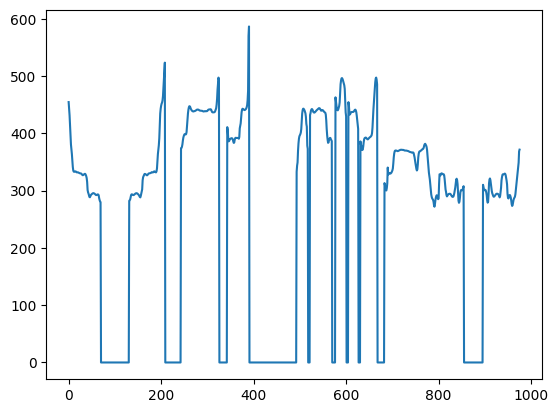

In [18]:
plt.plot(f0)

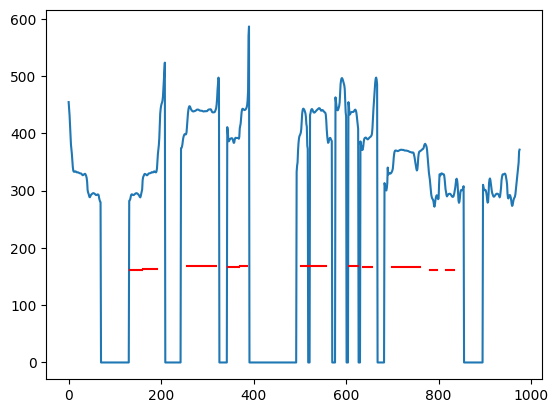

In [62]:
from anticipation.vocab import DUR_OFFSET
# make sure notes kinda fit (time, not note)
midiEndTime = letsVibe[-3] + (letsVibe[-2] - DUR_OFFSET)
timeFactor = 1

plt.plot(f0)
for t, d, n in zip(letsVibe[::3], letsVibe[1::3], letsVibe[2::3]):
    xStart = t*timeFactor + 100 # FIND WHERE THIS DELAY COMES FROM
    xEnd = xStart + (d-DUR_OFFSET)*timeFactor
    plt.plot([xStart, xEnd], [100+n-NOTE_OFFSET, 100+n-NOTE_OFFSET], color='r')

plt.show()

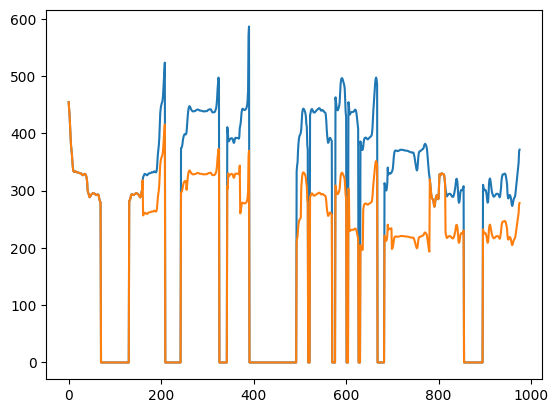

In [66]:
# from first harmony to second harmony, apply transposition
f0_harm1 = np.copy(f0)
for i in range(len(harmonies[0])-1):
    t1, h1 = harmonies[0][i]
    t2, h2 = harmonies[0][i+1]
    f0_harm1[100+t1:100+t2] *= pow(2, h1/12)

f0_harm1[100+t2:] *= pow(2, h2/12)

plt.plot(f0)
plt.plot(f0_harm1)